In [1]:
%pylab inline
import scipy.sparse as sp
from scipy.linalg import hadamard as hadamard
from sympy import isprime as isprime
from math import gcd as GCD
from scipy.sparse import diags as sparse
from scipy.sparse.linalg import eigsh as eigval

Populating the interactive namespace from numpy and matplotlib


In [2]:
    "parameters of the system and operators"

    
    "Number to be decomposed"
    N=21
    
    "control and target registers size"
    L=math.ceil(math.log2(N))
    control_size=2**(2*L)
    target_size=2**L
    
    
    """
    superposition of dimension 2**2L x 2**2L, to be constructed only once.
    Avoided memorization of the H_2L Hadamard operator, since it's not sparse.
    control_superposition= H^2L |0>
    """  
    control_superposition=np.ones(control_size)/control_size
    
    print("qubits required= ",3*L)

qubits required=  15


In [3]:
def why_entanglement_entropy(k,Y,N):
    '''
    Returns the entanglement entropy up to the k-th computational step S_{k,r}
    It uses a lot of useless stuff
    Parameters
        ----------
        N:  Integer
            Number to be factorized
            
        Y : Integer 
            Randomly sampled in [2,N-1]. It's a coprime of N
            
        k: Integer
           Computational step
    '''
    
    size=2**k
    
    #nonzero diagonal elements
    nonzero=[(Y**m) %N for m in range(0,size)]
    
    #sparse reduced density matrix
    rho_k= sparse(  [nonzero.count(i)/size for i in range(size)] )
    
    eigvals,_= eigval(rho_k,k=size)
    return sum([-l*log2(l) for l in eigvals])

In [4]:
def entanglement_entropy(k,Y,N):
    '''
    Since density matrix has only few nonzero diagonal elements,
    u can check how many they're and compute directly eigenvalues
    '''
    if(k>2*ceil(log2(N))):
        raise ValueError("Illegal argument: "+str(k)+"th computational step does not make sense in a "+str(2*ceil(log2(N)))+" control register")
    
    size=2**k
    
    #nonzero diagonal elements
    nonzero=[]
    nonzero.append(1)
    m=1
    while(((Y**m) % N!=1) and (m<size)):
        nonzero.append((Y**m) % N)
        m+=1

    #nonzero=[(Y**m) %N for m in range(0,size)]
    
    #order
    r=len(nonzero)
    
    q=int(floor(size/r))
    c=size-q*r

    #eigvals=[nonzero.count(i)*1.0/size for i in nonzero[0:order]]
    #return -sum([l*log2(l) for l in eigvals])
    
    return -(r-c)*q*1.0/size * log2(q/size)-c*(q+1)/size * log2((q+1)/size)

from sympy.ntheory import factorint

def prime_power(N) -> bool:
    """
            Check if the argument N is a prime power, i.e. exist p prime and i $
            If the argument is is a prime power, True is returned, otherwise False
            Parameters
            ----------
            N:  Integer
            Candidate prime power

    """
    
    factors = factorint(N) 
    bases = list(factors.keys())   
    expos = list(factors.values())

    base=int(bases[0])            

    expo = int(expos[0])            

    if N!=base**expo: 
        return 1
    else:
        return base

def Lfy(N):
    return int(ceil(log2(N)))

## ENTANGLEMENT ENTROPY AS A FUNCTION OF COMPUTATIONAL STEP FOR FIXED N##

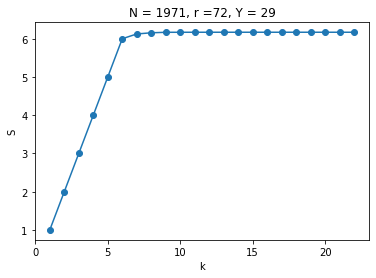

6.169925001442312


In [5]:
##Figure 3 emulation: N=15, Y=13

from sympy.ntheory.residue_ntheory import n_order as order
Y = 29
candidates=[i for i in range(N+2,2001,2) if( (not isprime(i)) and (prime_power(i)==1) and (gcd(Y,i)==1) ) ]
orders = [order(Y,i) for i in candidates]

N__ = 1971
L=int(ceil(log2(N__)))
res=[]
for k in range(1,2*L+1):
    res.append(entanglement_entropy(k,Y,N__))

r = order(Y, N__)
plot(range(1,2*L+1),res,'-o')
title('N = '+str(N__)+', r =' + str(r) +", Y = " +str(Y))
xlabel('k')
ylabel('S')
#savefig('Register_Dynamics_evolution_Y_'+str(Y)+'_N_'+str(N__), dpi=400)
show()
print(np.log2(r))
#It's true that it needs log(r) computational steps and arrives to S(r)=log(r)

## HEATMAP##

In [6]:
def heatmap_data():
    #odd numbers which are nor primes nor prime powers in [0,2000]: list of Ns
    candidates=[i for i in range(15,2001,2) if( (not isprime(i)) and (prime_power(i)==1) ) ]
    return [[(N,Y,entanglement_entropy(2*Lfy(N),Y,N)) for Y in range(2,N) if(GCD(Y,N)==1)] for N in candidates]

In [7]:
%%time
#data=heatmap_data()
#30 entries: 16.4 ms,   60: 70ms, 120:  330, 250: 3.34, 500: 46 s, 1000: 13 1/2 min

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


In [8]:
import pickle
#with open("heatmap_2.txt", "wb") as fp:
#    pickle.dump(data, fp)
    
with open("heatmap_2.txt", "rb") as fp:
    newdata = pickle.load(fp)
    
N_axis=array([x[0] for j in range(len(newdata)) for x in newdata[j]])
Y_axis=array([x[1] for j in range(len(newdata)) for x in newdata[j]])
S_axis=array([x[2] for j in range(len(newdata)) for x in newdata[j]])

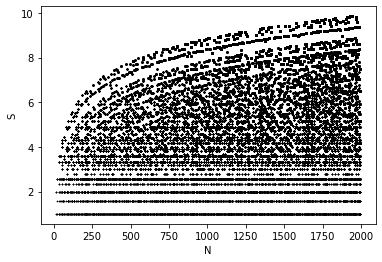

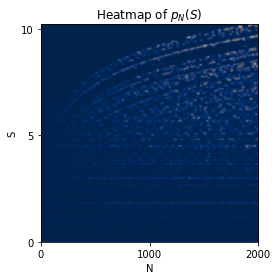

In [9]:
#down,up=[0,len(N_axis)]
#plt.scatter(N_axis[down:up], S_axis[down:up], c=Y_axis[down:up], marker='s',cmap='binary' ,s=.5)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def myplot(x, y, s, bins=(400,500)):
    heatmap, xedges, yedges= np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


x = N_axis
y = S_axis

#sigmas = [0, 3]

plt.plot(x, y, 'k.', markersize=1)
plt.xlabel('N')
plt.ylabel('S')
#plt.savefig('scatterplot_contro_target_last_k', dpi= 400)
plt.show()

fig,ax = plt.subplots()
img, extent = myplot(x, y, 2)
ax.imshow(img, cmap=plt.get_cmap("cividis"), extent=[0,2000,0,1000], origin = 'lower')
ax.set_title('Heatmap of $p_N(S)$')
ax.set_xlabel('N')
ax.set_ylabel('S')
ax.set_xticks(range(0,2001,1000))
ax.set_yticks(range(0,1001,490))
ax.set_yticklabels(['0','5','10'])
ax.set_aspect(2)

#plt.savefig("heatmap_control_target",dpi=400)
plt.show()

## mean order

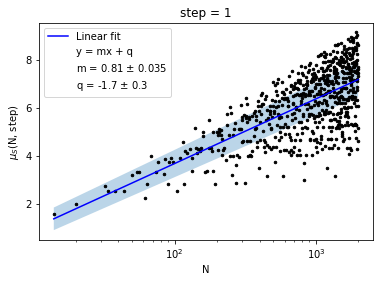

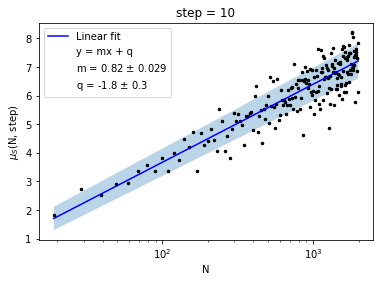

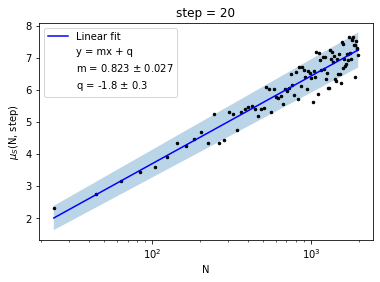

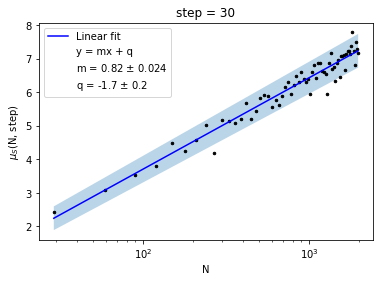

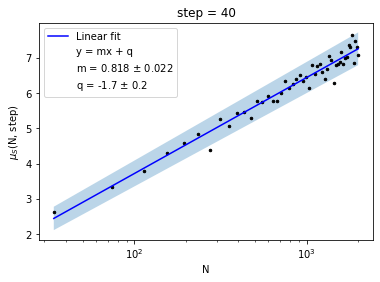

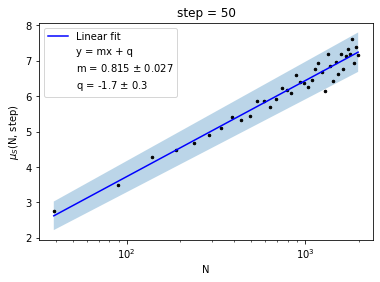

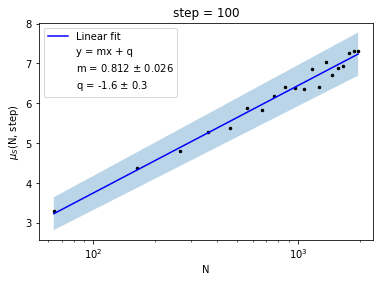

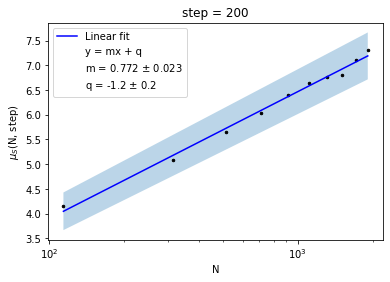

In [11]:
from scipy.optimize import curve_fit

def find_first(x):
    idx, step = 0, 32
    while idx < x.size:
        nz, = x[idx: idx + step].nonzero()
        if len(nz): # found non-zero, return it
            return nz[0] + idx
        # move to the next chunk, increase step
        idx += step
        step = min(9600, step + step // 2)
    return -1

def find_first_value_greater_than(x: np.array, value: float) -> float:
    rescaled = x - value
    bool_array = rescaled * (rescaled>0)
    idx_first_nonzero_in_rescaled = find_first(bool_array)
    return x[idx_first_nonzero_in_rescaled]

def get_std_error(x,y, regressor):
    N = len(x)
    p = x.shape[1]+1
    
    X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
    X_with_intercept[:, 0] = 1
    X_with_intercept[:, 1:p] = x
    
    y_pred = regressor.predict(x)
    m = regressor.coef_[0][0]
    q = regressor.intercept_[0]
    
    residuals = y - y_pred
    residual_sum_of_squares = residuals.T @ residuals
    sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
    var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
    
    for p_ in range(p):
        standard_error = var_beta_hat[p_, p_] ** 0.5
        if p_ ==0 : print("m = " +str(m) + ", std_Dev = " + str(standard_error))
        else: print("q = " + str(q)+ ", std_Dev = " + str(standard_error))
    return np.sqrt(diag(var_beta_hat))

def f(x,m,q):
    return m*x+q



uniq = np.unique(x)
for step in [1,10,20,30,40,50,100,200]:
    bin_edges_idx = []

    for j in range(x[0]-1,x[-1]+step,step):
        value = find_first_value_greater_than(uniq, j)
        
        filtered = x - value + 1
        filtered = filtered * (filtered>0)
        bin_edges_idx.append(find_first(filtered))
       
    means = [np.mean(y[bin_edges_idx[i]:bin_edges_idx[i+1]]) for i in range(len(bin_edges_idx)-1)]
    medium_points = np.array(range(x[0]-1 + step//2,x[-1]+step//2,step))
    
    semilogx(medium_points, means, 'k.', color='black', markersize=5)
    #plot(medium_points[medium_points<130], np.power(2,means)[medium_points<130], 'k.', color='red', markersize=5)
    title('step = ' + str(step))
    xlabel('N')
    ylabel('$\mu_S$(N, step)')    
    
    nan_idx = np.argwhere(np.isnan(means)).flatten()
    x_reg = np.delete(np.log2(medium_points),nan_idx)
    y_reg = np.delete(means,nan_idx)
    params, pcov = curve_fit(f,x_reg, y_reg)
    perr = np.sqrt(np.diag(pcov))
    y_pred = params[0] * x_reg + params[1]
    y_down = (params[0]-perr[0]) * x_reg + (params[1]-perr[1])
    y_up = (params[0]+perr[0]) * x_reg + (params[1]+perr[1])
    
    plot(np.power(2,x_reg),y_pred, '-', color='blue', label = "Linear fit") 
    fill_between(np.power(2,x_reg), y_up, y_down, alpha=0.3)
    plot([],[],color= "white", label ="y = mx + q")
    plot([],[],color= "white", label ="m = {} $\pm$ {}".format(round(params[0],3),round(perr[0],3)))
    plot([],[],color= "white", label = "q = {} $\pm$ {}".format(round(params[1],1),round(perr[1],1)))
    
    legend()
    savefig('registers_average_entropy_'+str(step), dpi=400)
    show()

## Convex Hull

In [ ]:
S_max=[np.max(newdata[i],axis=0)[2] for i in range(len(newdata))]
N_max=[newdata[i][0][0] for i in range(len(newdata))]

plt.plot(N_max, S_max,'o', markersize=1,color='black')
plt.xlabel('N')
plt.ylabel('$\hat{S}$')
plt.plot(N_max, 1.095 * np.log2(N_max)-2.04,'--',color='red',linewidth=1.5,alpha=.9,label="1.095 log$_2$(N)-2.04")
plt.plot(N_max, np.log2(N_max)-1.6,'-',color='blue',linewidth=1.5,alpha=.9,label="$log_2$(N)-1.6")
plt.legend()
plt.tight_layout()
#plt.savefig('convex_hull_registers', dpi=400)
plt.show()

y = '$\hat{S}$'
plt.semilogx(N_max, S_max,'o', markersize=2,color='black', alpha=0.5)
plt.ylabel(y, fontsize=13)
plt.semilogx(N_max, 1.095*np.log2(N_max)-2.04,'--',color='red',linewidth=1.5,alpha=.9,label="$1.095 * log_2$(N)-2.04")
plt.semilogx(N_max, np.log2(N_max)-1.6,'-',color='blue',linewidth=1.5,alpha=.9,label="$log_2$(N)-1.6")
plt.xlabel('N')
plt.legend()
plt.tight_layout()
#plt.savefig('convex_hull_registers_logarithmic', dpi=400)
plt.show()

## Distribution of r(Y) for N fixed

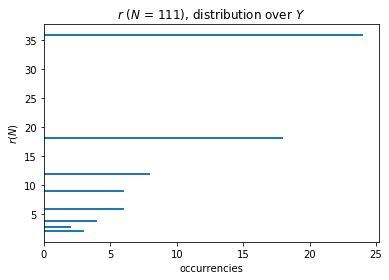

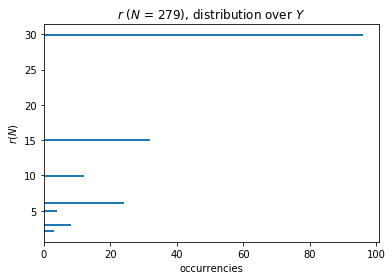

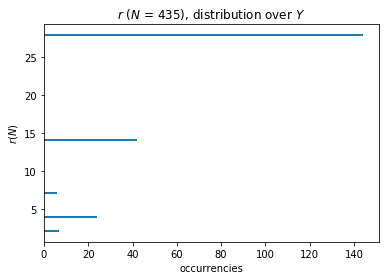

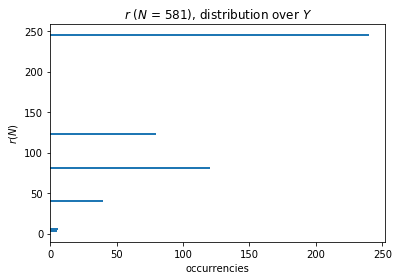

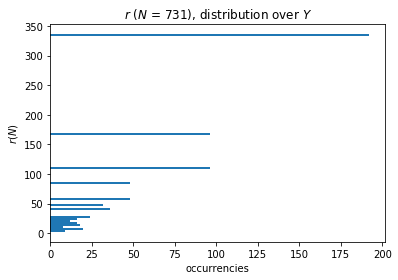

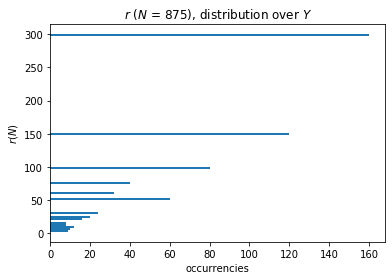

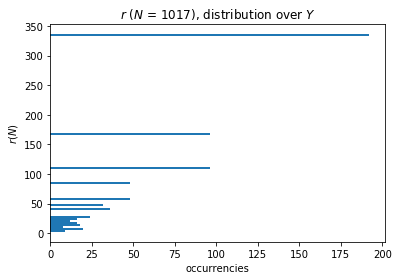

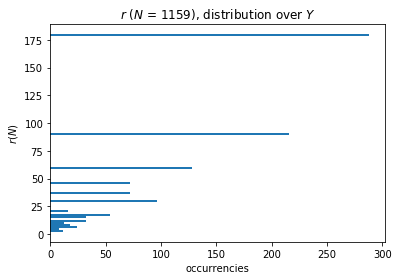

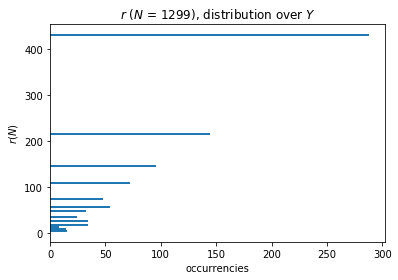

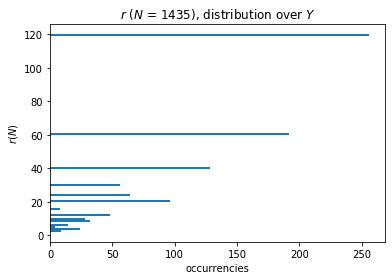

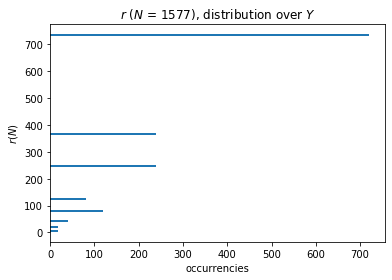

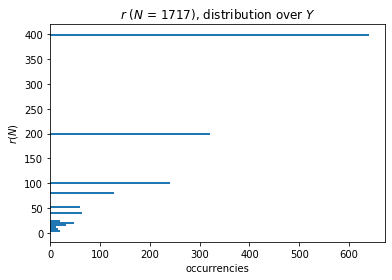

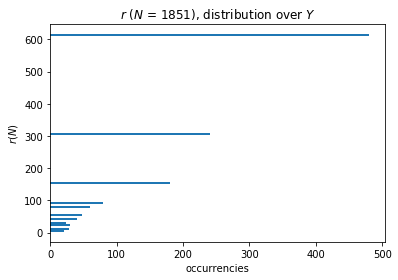

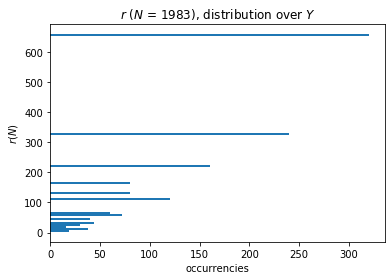

In [54]:
from random import randint

uniq = np.unique(N_axis)

tries=10
#for i in range(tries):
for fixed_N in uniq[21::50]:
    #fixed_N = uniq[randint(0,len(uniq)-1)]
    fixed_N = int(fixed_N)
    Y_d = [i for i in  range(2,fixed_N) if GCD(i,fixed_N)==1]
    r_d = np.array([order(i,fixed_N) for i in Y_d])


    plt.title("$r$ $(N$ = {}), distribution over $Y$".format(fixed_N))
    plt.hist(r_d,  orientation='horizontal', bins=100)
    plt.xlabel("occurrencies")
    plt.ylabel("$r(N)$")
    plt.savefig('order_fixed_N_'+str(fixed_N)+'_distribution')
    plt.show()

## COMPLETE ALGORITHM WITH CLASSICAL PART##

In [ ]:
def shor(N):
    """
            Find a non trivial divisor of N
            Parameters
            ----------
            N:  Integer
                Number to be factorized

    """

    if(N%2==0): return 2
    if isprime(N):
        print(N," is a prime number")
        return 1
    
    p=prime_power(N)
    if(p!=1): return p
    
    #random extraction
    
    #candidates=list(range(3,N))
    #Y=random.choice(candidates)
    
    Y=randint(2,N)
    used=[]
    while 1:
        a=GCD(Y,N)
        if (a>1): return a
        
        #N,Y coprimes
        
        r=order_finding(N,Y)
        if(r%2==0):
            s=r/2.
            
            factor=(Y**s+1% N)
            if(factor!=0):
                a=GCD(factor,N)
                if ( a>1 ): return a
                else: return GCD(Y**s-1 %N,N)
        
        #this Y is stored as used and a new Y is extracted. The whole while() is repeated
        used.append(Y)
        Y=randint(2,N)
        while(Y in used):
            Y=randint(2,N)
            
        #candidates.remove(Y)
        #Y=random.choice(candidates)